# Criando o grafo de analise do wikipidea

O objetivo desta atividade é criar um grafo em que os nós representem páginas da Wikipedia, utilizando os links presentes nessas páginas para estabelecer conexões entre os nós.

a partir do notebook [Case Study: constructing a network of wikipedia pages](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week_09/Wikipedia.ipynb) desenvolvido pelo professor Ivanovitch foi possível criar o grafo.

## importando a lib do wikipédia

In [ ]:
!pip install wikipedia

In [26]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import pandas as pd

## Criando a função para criação do grafo

In [29]:
def print_nodes_edges(graph):
    """
        função para printar o número de nós e de arestas do grafo passado como argumento

        args:
            - graph: grafo a ser usado para printar o número de nós e arrestas

        return:
            - print
    """

    
    return print("{} nodes, {} edges".format(len(graph), nx.number_of_edges(graph)))

def get_nodes_edges(graph):
    """
        função que obtem o numero de nos e arestas do grafo

        args:
            - graph: grafo ao qual se quer obter os dados

        return:
            - numero de nós
            - numero de arestas
    """

    return len(graph), nx.number_of_edges(graph)

def create_graph(SEED):
    """
        função para criar o grafo de citações de páginas da wikipedia através de uma página raiz (seed)

        args:
            - seed: Nome da página raiz, nó inicial do grafo

        return:
            - g: grafo resultante
    """

    todo_lst = [(0, SEED)] # The SEED is in the layer 0
    todo_set = set(SEED) # The SEED itself
    done_set = set() # Nothing is done yet

    g = nx.DiGraph()
    layer, page = todo_lst[0]

    while layer < 2:
      # Remove the name page of the current page from the todo_lst,
      # and add it to the set of processed pages.
      # If the script encounters this page again, it will skip over it.
      del todo_lst[0]
      done_set.add(page)
    
      # Show progress
      print(layer, page)
    
      # Attempt to download the selected page.
      try:
        wiki = wikipedia.page(page)
      except:
        print("Could not load", page)
        layer, page = todo_lst[0]
        continue
    
      for link in wiki.links:
        link = link.title()
        if link not in STOPS and not link.startswith("List Of"):
          if link not in todo_set and link not in done_set:
            todo_lst.append((layer + 1, link))
            todo_set.add(link)
          g.add_edge(page, link)
      layer, page = todo_lst[0]
        
    return g

## Definindo os seeds dos grafos

Foram definidos como páginas raizes as seguintes páginas:

- **Nordeste Brasileiro**;
- **Capoeira**;
- **Forró**;

In [7]:
#https://en.wikipedia.org/wiki/Complex_network
SEED_NORDESTE = "Nordeste Brasileiro".title()
SEED_CAPOEIRA = "Capoeira".title()
SEED_FORRO = "Forro".title()

STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")

## Criando o grafo com a seed "Nordeste Brasileiro"


In [ ]:
%%time
grafo_nordeste = create_graph(SEED_NORDESTE)

## Criando o grafo com a seed "Capoeira"

In [ ]:
%%time
grafo_capoeira = create_graph(SEED_CAPOEIRA)

## Criando o grafo com a seed "Forro"

In [ ]:
%%time
grafo_forro = create_graph(SEED_FORRO)

## Criando um função para eliminar páginas duplicadas

In [36]:
def eliminate_duplicate_pages(graph):
    """
        Algumas páginas que são as mesmas são tratadas como paginas diferentes apenas por conter alguma formatação diferente com:
            - finalizar com s
            - conter o "-"

        args:
            - graph: grafo a ser filtrado

        return:
            - graph: grafo filtrado
    """
    
    # remove self loops
    graph.remove_edges_from(nx.selfloop_edges(graph))
    
    # identify duplicates like that: 'network' and 'networks'
    duplicates = [(node, node + "s")
                  for node in graph if node + "s" in graph
                 ]
    
    for dup in duplicates:
      # *dup is a technique named 'unpacking'
      graph = nx.contracted_nodes(graph, *dup, self_loops=False)
    
    print(duplicates)
    
    duplicates = [(x, y) for x, y in
                  [(node, node.replace("-", " ")) for node in graph]
                    if x != y and y in graph]
    print(duplicates)
    
    for dup in duplicates:
      graph = nx.contracted_nodes(graph, *dup, self_loops=False)
    
    # nx.contracted creates a new node/edge attribute called contraction
    # the value of the attribute is a dictionary, but GraphML
    # does not support dictionary attributes
    nx.set_node_attributes(graph, 0,"contraction")
    nx.set_edge_attributes(graph, 0,"contraction")

    return graph

## Eliminando as páginas duplicadas

In [ ]:
grafo_nordeste_clean = eliminate_duplicate_pages(grafo_nordeste)
grafo_capoeira_clean = eliminate_duplicate_pages(grafo_capoeira)
grafo_forro_clean = eliminate_duplicate_pages(grafo_forro)

## Analisando o graus dos nós e seus vizinhos


In [37]:
def histogram_degree(graph):
    """
        Função para plotar um histograma da visão geral dos graus do grafo

        args:
            - graph: grafo a ser plotado

        return:
            - None
    """

    plt.style.use("default")
    # degree sequence
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    
    # all_data has information about degree_sequence and the width of each bin
    ax[0].hist(degree_sequence)
    ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])
    
    ax[0].set_title("Degree Histogram")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel("Degree")
    ax[0].set_ylim(0,15000)
    
    ax[1].set_title("Degree Histogram - Zoom")
    ax[1].set_ylabel("Count")
    ax[1].set_xlabel("Degree")
    ax[1].set_xlim(0,10)
    ax[1].set_ylim(0,15000)
    
    plt.tight_layout()
    plt.show()

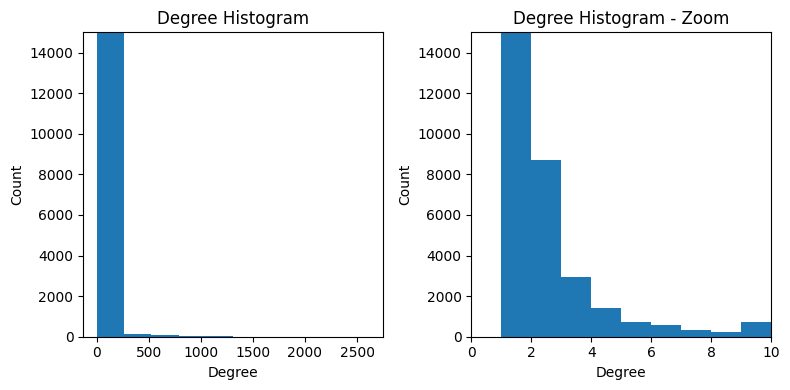

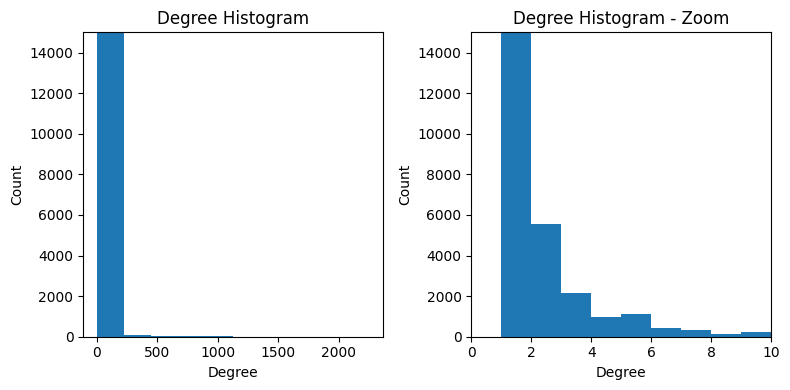

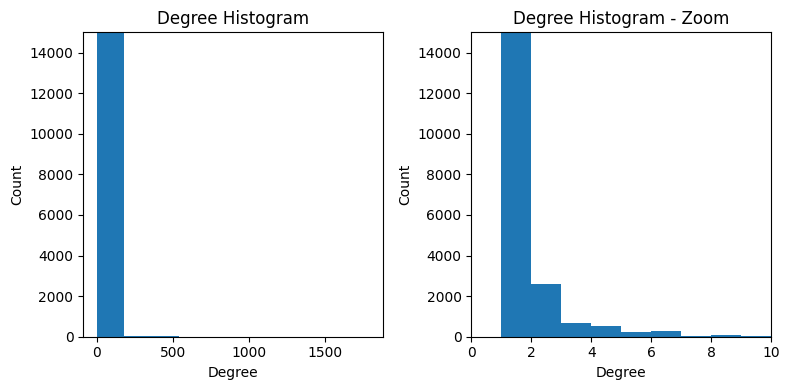

In [22]:
histogram_degree(grafo_nordeste)
histogram_degree(grafo_capoeira)
histogram_degree(grafo_forro)


## Fazendo o truncamento do gráfico

In [38]:
def trunc_graph(graph):
    """
       Retirando páginas que possuem apenas um link, ou seja, obtendo um subgrafo com nós que possuem grau maior ou igual a 2

       args:
            - graph: grafo a ser truncado

        return:
            - gsub: subgrafo com o truncamento feito
    """

    # filter nodes with degree greater than or equal to 2
    core = [node for node, deg in dict(graph.degree()).items() if deg >= 2]
    
    # select a subgraph with 'core' nodes
    gsub = nx.subgraph(graph, core)

    return gsub

In [25]:
grafo_nordeste_final = trunc_graph(grafo_nordeste_clean)
grafo_capoeira_final = trunc_graph(grafo_capoeira_clean)
grafo_forro_final = trunc_graph(grafo_forro_clean)

## Comparando o tamanho do grafo original com o subgrafo final

Depois de todas as "filtragens" realizadas obtivemos a seguinte comparação:

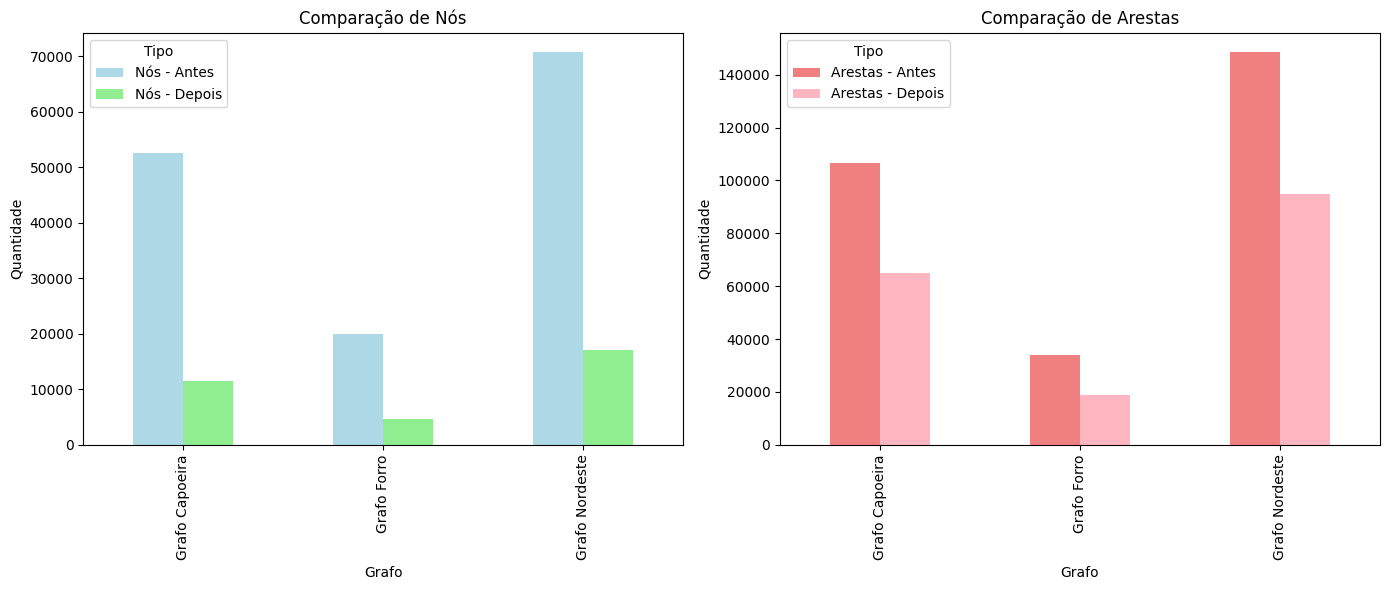

In [32]:
# obtendo o numero de nos e links antes e depois da filtragem
nodes_nordeste_antes, edges_nordeste_antes = get_nodes_edges(grafo_nordeste)
nodes_nordeste_depois, edges_nordeste_depois = get_nodes_edges(grafo_nordeste_final)

# obtendo o numero de nos e links antes e depois da filtragem
nodes_capoeira_antes, edges_capoeira_antes = get_nodes_edges(grafo_capoeira)
nodes_capoeira_depois, edges_capoeira_depois = get_nodes_edges(grafo_capoeira_final)

# obtendo o numero de nos e links antes e depois da filtragem
nodes_forro_antes, edges_forro_antes = get_nodes_edges(grafo_forro)
nodes_forro_depois, edges_forro_depois = get_nodes_edges(grafo_forro_final)

data = {
    'Grafo': ['Grafo Nordeste', 'Grafo Nordeste', 'Grafo Capoeira', 'Grafo Capoeira', 'Grafo Forro', 'Grafo Forro'],
    'Tipo': ['Nós - Antes', 'Nós - Depois', 'Nós - Antes', 'Nós - Depois', 'Nós - Antes', 'Nós - Depois'],
    'Quantidade': [nodes_nordeste_antes, nodes_nordeste_depois, nodes_capoeira_antes, nodes_capoeira_depois, nodes_forro_antes, nodes_forro_depois]
}

df_nos = pd.DataFrame(data)

data_arestas = {
    'Grafo': ['Grafo Nordeste', 'Grafo Nordeste', 'Grafo Capoeira', 'Grafo Capoeira', 'Grafo Forro', 'Grafo Forro'],
    'Tipo': ['Arestas - Antes', 'Arestas - Depois', 'Arestas - Antes', 'Arestas - Depois', 'Arestas - Antes', 'Arestas - Depois'],
    'Quantidade': [edges_nordeste_antes, edges_nordeste_depois, edges_capoeira_antes, edges_capoeira_depois, edges_forro_antes, edges_forro_depois]
}

df_arestas = pd.DataFrame(data_arestas)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de Nós
df_nos.pivot(index='Grafo', columns='Tipo', values='Quantidade').plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen'])
axes[0].set_title('Comparação de Nós')
axes[0].set_ylabel('Quantidade')
axes[0].set_xlabel('Grafo')

# Gráfico de Arestas
df_arestas.pivot(index='Grafo', columns='Tipo', values='Quantidade').plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightpink'])
axes[1].set_title('Comparação de Arestas')
axes[1].set_ylabel('Quantidade')
axes[1].set_xlabel('Grafo')

plt.tight_layout()
plt.show()

## Criando o Grafo principal

O grafo principal será feito unindo os 3 grafos criados anteriormente.

- **GRAFO PRINCIPAL** = GRAFO_NORDESTE_FINAL + GRAFO_CAPOEIRA_FINAL + GRAFO_FORRO_FINAL

In [39]:
grafo_principal = nx.compose_all([grafo_nordeste_final,grafo_capoeira_final,grafo_forro_final])
print_nodes_edges(grafo_principal)

#exportando o grafo principal para graphml
nx.write_graphml(grafo_principal, "grafo.graphml")

28774 nodes, 173548 edges
